In [15]:
# Goals of this step: address missing data and redundant features.
#
# As preliminary, regenerate the test and training sets from previous step.
import pandas as pd
datapath="/Users/jasonmiller/Source/MachineLearning/datasets/housing/housing.csv"
all_data=pd.read_csv(datapath)
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(all_data,test_size=0.2,random_state=42)

# Make a copy for playing around.
sts=train_set.copy()

# Return to issue of missing data.
# Recall there were 207 null bedroom counts and all of them ended up in the test set.
# Write fixer code that can be applied to train and test data. (Validation data?)
# Generalize the fix to all columns since real data could have NaN anywhere.
# Choice 1 = remove whole rows i.e. data points: sts.dropna(subset=["total_bedrooms"])
# Choice 2 = remove whole columns i.e. features: sts.drop("total_bedrooms",axis=1)
# Choice 3 = change NaN to 3000 i.e. sts["total_bedrooms"].fillna(3000,inplace=True)
# Choice 4 = use an imputer. Hits every column. Requires us to put aside non-numeric columns.
#           Using median will perhaps have the least effect on outcome.
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy="median")
numeric_only = sts.drop("ocean_proximity",axis=1)
imputer.fit(numeric_only)
numpy_array = imputer.transform(numeric_only)  # replace NaN with column median in every column
numeric_sts = pd.DataFrame(numpy_array,columns=numeric_only.columns,index=numeric_only.index)
numeric_sts.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

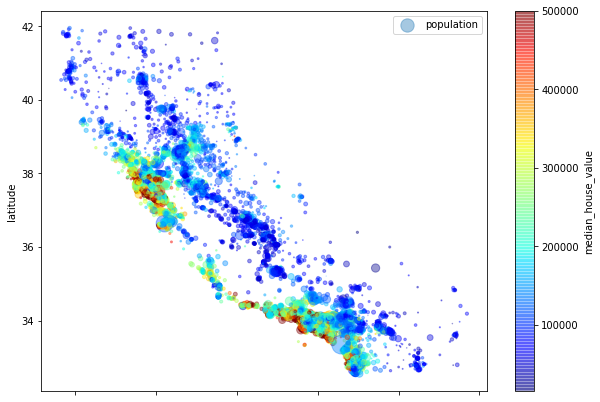

In [4]:
# Visualize geographically.
# Size(s)=pop. Color(c)=prices. (x,y)=map coords.
import matplotlib.pyplot as plt
sts.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
        s=sts["population"]/100, label="population", figsize=(10,7),
        c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1160f5e20>,
      dtype=object)

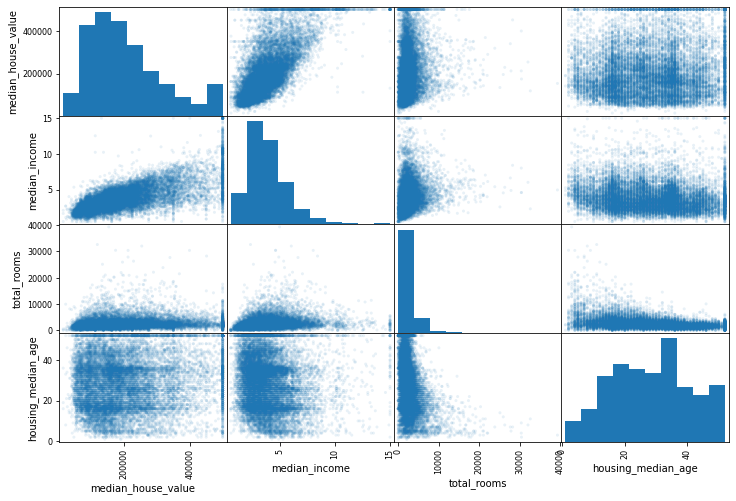

In [6]:
# Look for correlations graphically.
from pandas.plotting import scatter_matrix
attributes=["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(sts[attributes],figsize=(12,8),alpha=0.1)
# Note caps: solid lines where all larger values were lumped into max category.

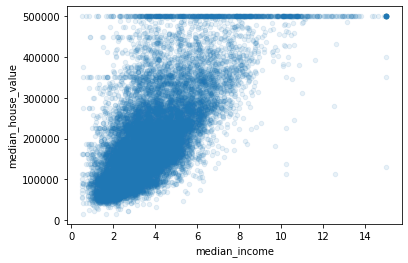

In [7]:
# Alternate visualation: make plot with dataframe directly.
sts.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)

In [17]:
# Look at correlation matrix. 
# Warning: correlation tests for linear relationships only.
# County median house value correlates most closely to to county median income. (Helpful.)
# County total bedrooms correlates most closely to count total households. (Not helpful.)
sts.corr()
# Observation 1: 
# County total bedrooms correlates most closely to count total households.
# This data seems redundant. We will create combination features later.
# Observation 2: 
# County median house value correlates closely to to county median income.
# Thus income is probably an imporant feature.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924485,-0.101818,0.038676,0.063064,0.094276,0.049306,-0.017040,-0.046349
latitude,-0.924485,1.000000,0.005296,-0.029224,-0.059998,-0.102499,-0.064061,-0.076571,-0.142983
housing_median_age,-0.101818,0.005296,1.000000,-0.360922,-0.320624,-0.292283,-0.302796,-0.121711,0.103706
total_rooms,0.038676,-0.029224,-0.360922,1.000000,0.930489,0.857936,0.920482,0.198268,0.133989
total_bedrooms,0.063064,-0.059998,-0.320624,0.930489,1.000000,0.878932,0.980255,-0.009141,0.047980
population,0.094276,-0.102499,-0.292283,0.857936,0.878932,1.000000,0.907452,0.004122,-0.026032
households,0.049306,-0.064061,-0.302796,0.920482,0.980255,0.907452,1.000000,0.012776,0.063714
median_income,-0.017040,-0.076571,-0.121711,0.198268,-0.009141,0.004122,0.012776,1.000000,0.690647
median_house_value,-0.046349,-0.142983,0.103706,0.133989,0.047980,-0.026032,0.063714,0.690647,1.000000


In [8]:
# Invent new features as combinations of existing features.
sts["rooms_per_household"]=sts["total_rooms"]/sts["households"]
sts["bedrooms_per_room"]=sts["total_bedrooms"]/sts["total_rooms"]
sts["population_per_household"]=sts["population"]/sts["households"]
# Look at correlation of new features.
# Rooms per household correlates with county median income.
sts[sts.columns[5:]].corr(method="spearman")

,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
population,1.000000,0.902887,0.004239,0.004115,-0.106319,0.071406,0.241225
households,0.902887,1.000000,0.026796,0.112578,-0.113251,0.097262,-0.141366
median_income,0.004239,0.026796,1.000000,0.678132,0.643557,-0.747277,-0.043947
median_house_value,0.004115,0.112578,0.678132,1.000000,0.261299,-0.333135,-0.257736
rooms_per_household,-0.106319,-0.113251,0.643557,0.261299,1.000000,-0.886623,0.020672
bedrooms_per_room,0.071406,0.097262,-0.747277,-0.333135,-0.886623,1.000000,-0.083119
population_per_household,0.241225,-0.141366,-0.043947,-0.257736,0.020672,-0.083119,1.000000
